In [1]:
import sys
sys.path.append("..")

In [2]:
import squlearn as squ
import matplotlib.patches as mpatches


squlearn.encoding_circuit.__init__.py running


In [10]:
from circuits.circuits import Separable_rx, IQPLikeCircuit

from models.concentration_bounds import A_expressibility, haar_frame_potential, subspace_dimension
from squlearn.kernel import ProjectedQuantumKernel, FidelityKernel
from qiskit.primitives import Estimator, Sampler
from squlearn.util import Executor
import numpy as np
from models.manual_kernels import *
from data_tools.tools import  *


import seaborn as sns
import matplotlib.pyplot as plt


from matplotlib import rc
rc('text', usetex=True)


sns.set_context("paper", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":16, 
                             "legend.fontsize":14, "xtick.labelsize":16, 
                             "ytick.labelsize":16, "legend.title_fontsize":14,  'lines.linewidth': 3, 'lines.markersize': 6})

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
    })



In [4]:
kernels1L = pd.DataFrame(read_experiment_dic_results("../data/results/kernels_2_19.h5", ignore_Ks=False, short_load=False))

In [5]:
def varK_analytical(c, num_qubits, num_layers):
    c = c*num_layers
    EKXY = 1/2 - np.cos(2*np.pi*c)/(4*np.pi**2*c**2) + 1/(4*np.pi**2*c**2)
    EKXYsquare = 3/8 - np.cos(2*np.pi*c)/(4*np.pi**2*c**2) - np.cos(4*np.pi*c)/(64*np.pi**2*c**2) + 17/(64*np.pi**2*c**2)
    
    return EKXYsquare**num_qubits - (EKXY**(2*num_qubits))
    
def varK_analytical_limits(c, num_qubits, num_layers, limit="small"):
    c = c*num_layers
    if limit == "large":
        #(-2**(5*n_{qubits}) + 2**(4*n_{qubits})*3**n_{qubits})/2**(7*n_{qubits})
        return (-2**(5*num_qubits) + 2**(4*num_qubits)*3**num_qubits)/2**(7*num_qubits)
    elif limit == "small":
        #7*pi**4*c**4*n_{qubits}/180
        return 7*np.pi**4*c**4*num_qubits/180
    
def expressibility_analytical(c, num_qubits, num_layers):
    c = c*num_layers
    E2kXY = 3/8 - np.cos(2*np.pi*c)/(4*np.pi**2*c**2) - np.cos(4*np.pi*c)/(64*np.pi**2*c**2) + 17/(64*np.pi**2*c**2)
    return np.sqrt(E2kXY**num_qubits - haar_frame_potential(2, 2**num_qubits))
def expressibility_analytical_limits(c, num_qubits, num_layers, limit="small"):
    c = c*num_layers
    if limit == "large":
        return np.sqrt((3/8)**num_qubits - haar_frame_potential(2, 2**num_qubits))
    elif limit == "small":
        return np.sqrt(1 - haar_frame_potential(2, 2**num_qubits))
    
def eta_max_analytical(c, num_qubits, num_layers):
    c = c*num_layers
    sinc_f = lambda x: np.sin(x)/x
    return ((3/8) + (1/8) * sinc_f(2 * np.pi * c) + (1/8) * np.sqrt((1 - sinc_f(2 * np.pi * c))**2 + 16 * sinc_f(np.pi * c)**2))**num_qubits


def eta_max_analytical_limits(c, num_qubits, num_layers, limit="small"):
    c = c*num_layers
    if limit == "large":
        return (1/2)**num_qubits
    elif limit == "small":
        return 1
    

    kernels = kernels1L.copy()

kernels = kernels1L.copy()
kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
kernels["varK_analytical_large"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

kernels["expressibility_analytical"] = kernels.apply(lambda x: expressibility_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
kernels["expressibility_analytical_small"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
kernels["expressibility_analytical_large"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

kernels["eta_max_analytical"] = kernels.apply(lambda x: eta_max_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
kernels["eta_max_analytical_small"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
kernels["eta_max_analytical_large"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

#A_expressibility(K, n_qubits, t=2)
kernels["varK_numerical"] = kernels.apply(lambda x: np.var(x["K_train"]), axis=1)
kernels["expressibility_numerical"] = kernels.apply(lambda x: A_expressibility(x["K_train"], x["num_qubits"], t=2), axis=1)
kernels["eta_max_numerical"] = kernels.apply(lambda x: np.max(x["eigenvalues"]), axis=1)



def analytical_quantities(kernels): 
    kernels["varK_analytical"] = kernels.apply(lambda x: varK_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["varK_analytical_small"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["varK_analytical_large"] = kernels.apply(lambda x: varK_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    kernels["expressibility_analytical"] = kernels.apply(lambda x: expressibility_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["expressibility_analytical_small"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["expressibility_analytical_large"] = kernels.apply(lambda x: expressibility_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    kernels["eta_max_analytical"] = kernels.apply(lambda x: eta_max_analytical(x["bandwidth"], x["num_qubits"], x["num_layers"]), axis=1)
    kernels["eta_max_analytical_small"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "small"), axis=1)
    kernels["eta_max_analytical_large"] = kernels.apply(lambda x: eta_max_analytical_limits(x["bandwidth"], x["num_qubits"], x["num_layers"], "large"), axis=1)

    #A_expressibility(K, n_qubits, t=2)
    # kernels["varK_numerical"] = kernels.apply(lambda x: np.var(x["K_train"]), axis=1)
    # kernels["expressibility_numerical"] = kernels.apply(lambda x: A_expressibility(x["K_train"], x["num_qubits"], t=2), axis=1)
    # kernels["eta_max_numerical"] = kernels.apply(lambda x: np.max(x["eigenvalues"]), axis=1)
    return kernels


top_eigenvalue_str = r"$\eta_{max}$"
varK_diagonal_str = "Var $K$"
expressibility_label = r"Expressibility $\epsilon_{\mathcal{U}_{\mathcal{X}}}$"

top_eigenvalue_str_simple = r"top_eigenvalue"
varK_diagonal_str_simple = "varK"
expressibility_label_simple = r"expressibility"

kernels1L = kernels1L.dropna(subset=["bandwidth"])

def calculate_metrics_nqubits(K, n_qubits):
    expressibility = A_expressibility(K, n_qubits, t=2)
    varK = np.var(K.flatten())
    top_eigenvalue = np.max(np.linalg.eigvalsh(K/np.shape(K)[0]))
    return expressibility, varK, top_eigenvalue

num_datapoints_max = kernels1L["K_train"].iloc[0].shape[0]
n_points = 5
num_datapoint_list = np.logspace(np.log10(10), np.log10(num_datapoints_max), n_points, dtype=int)
bandwidth_list = kernels1L["bandwidth"].unique()
seed_list = kernels1L["seed"].unique()


In [6]:
kernels_by_num_datapoints = pd.DataFrame()

rows_list = []
for i, row in kernels1L.iterrows():
    mask = (kernels1L["num_datapoints"] == row["num_datapoints"]) & (kernels1L["bandwidth"] == row["bandwidth"]) & (kernels1L["seed"] == row["seed"])
    masked_df = kernels1L[mask]
    for nq, n_qubits in enumerate(masked_df["num_qubits"].unique()):
        masked_df_nq = masked_df[masked_df["num_qubits"] == n_qubits]
        for j, num_datapoints in enumerate(num_datapoint_list):
            dict_row = {}
            K_train = masked_df_nq["K_train"].iloc[0][:num_datapoints, :num_datapoints]
            n_qubits = masked_df_nq["num_qubits"].iloc[0]
            expressibity, varK, top_eigenvalue = calculate_metrics_nqubits(K_train, n_qubits)
            dict_row.update({"num_datapoints": num_datapoints, 
                            "bandwidth": row["bandwidth"], 
                            "seed": row["seed"], 
                            "expressibility": expressibity, 
                            "varK_train": varK, 
                            "top_eigenvalue": top_eigenvalue, 
                            "num_qubits": n_qubits, 
                            "num_layers": row["num_layers"],
                            "dataset_name": row["dataset_name"],})
            rows_list.append(dict_row)
kernels_by_num_datapoints = pd.DataFrame(rows_list)

In [7]:
kernels_by_num_datapoints = kernels_by_num_datapoints.sort_values(by="num_qubits")
kernels_num_datapoints_analytical = analytical_quantities(kernels_by_num_datapoints)

#group by dataset_name, num_datapoints, num_layers, num_qubits, bandwidth and apply fit(num_qubits_list_np, varK_c_idx, exponential) 

num_layers_list = np.unique(kernels["num_layers"])
dataset_list = np.unique(kernels["dataset_name"])
num_datapoint_list = np.unique(kernels["num_datapoints"])
num_qubits_list = np.unique(kernels["num_qubits"])
bandwidth_list = np.unique(kernels["bandwidth"])


kernels_num_datapoints_analytical[varK_diagonal_str] = kernels_num_datapoints_analytical["varK_train"]
kernels_num_datapoints_analytical[top_eigenvalue_str] = kernels_num_datapoints_analytical[top_eigenvalue_str_simple]
kernels_num_datapoints_analytical[expressibility_label] = kernels_num_datapoints_analytical[expressibility_label_simple]


kernels_num_datapoints_analytical.reset_index(drop=True, inplace=True)
kernels_nq_d = kernels_num_datapoints_analytical



# Fig 3

C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_19920\2119318211.py:133: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale("log")


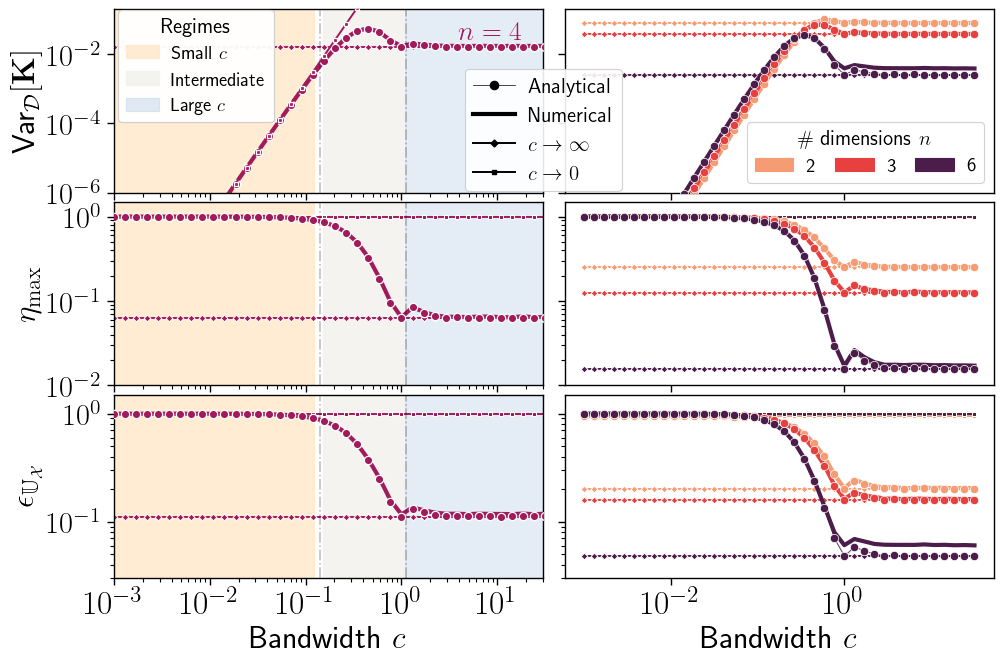

In [11]:
# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

sns.set_context("paper", rc={"font.size":12,"axes.titlesize":16,"axes.labelsize":24, 
                                "legend.fontsize":12, "xtick.labelsize":24, 
                                "ytick.labelsize":22, "legend.title_fontsize":12, })

xlabel_fontsize = 23
progressive_palette = sns.color_palette("rocket_r", n_colors=4)

#make a dictionary palette: 2, 3, 4, 6
palette_dict = {2: progressive_palette[0], 3: progressive_palette[1], 4: progressive_palette[2], 6: progressive_palette[3]}

colorblind_palette = sns.color_palette("colorblind", n_colors=len(num_qubits_list))
selected_palette=palette_dict


sc=0.85
fig, axs = plt.subplots(3, 2, figsize=(12*sc, 8*sc), sharey="row", sharex="col")
handle_textpad = 0.65

# Only num_qubits = 1 or 3 or 5
#kernels_nq = kernels[(kernels["num_qubits"] == 1)  | (kernels["num_qubits"] == 4)]
kernels_nq = kernels[kernels["num_qubits"] == 4]

c_list = kernels_nq["bandwidth"].unique()

numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"


linewidth_size = 3
intermediate_linewidth_size = 1.4
thinlinewidth_size = 0.5
scatter_size = 12
marker_size_analytical = 6
marker_size = marker_size_analytical
marker_size_limits = 3.5

marker_edge_width = 0.9

large_limit_style = "D"
small_limit_style = "s"
analytical_style = "o"


ax = axs[0, 0]
#create a text with text = "$n$=4"
ax.text(0.95, 0.94, "$n=4$", transform=ax.transAxes,  fontweight='bold', va='top', ha='right', size=20, color=palette_dict[4])

sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax,  marker=analytical_style, hue="num_qubits",  linewidth=thinlinewidth_size, markersize=marker_size_analytical, markeredgewidth=marker_edge_width, zorder=4, palette=selected_palette, legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_small", ax=ax, marker=small_limit_style, linewidth=intermediate_linewidth_size, markeredgewidth=marker_edge_width, color ='k', hue="num_qubits", palette = selected_palette, legend=False,zorder=10, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_large", ax=ax,  marker=large_limit_style, linewidth=intermediate_linewidth_size, color ='k', hue="num_qubits", palette = selected_palette, legend=False, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_numerical", ax=ax, linewidth = linewidth_size, linestyle='-', hue="num_qubits", palette = selected_palette, legend=False, zorder=2 )



ax.set_yscale("log")
ax.set_xscale("log")


ax = axs[1, 0]
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", ax=ax, label =analytical_str, zorder=10, hue="num_qubits",  marker=analytical_style,  linewidth=thinlinewidth_size, markersize=marker_size_analytical, markeredgewidth=marker_edge_width, palette=selected_palette, legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small", ax=ax, label =small_str, marker=small_limit_style, linewidth=intermediate_linewidth_size, hue="num_qubits", palette = selected_palette, legend=False, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", ax=ax, label=large_str, marker=large_limit_style, linewidth=intermediate_linewidth_size, hue="num_qubits", palette = selected_palette, legend=False, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_numerical", ax=ax, label=numerical_str, linewidth = linewidth_size, linestyle='-' , hue="num_qubits", palette = selected_palette, legend=False, )

ax = axs[2, 0]
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", ax=ax, label =analytical_str, zorder=10, marker=analytical_style,  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=marker_edge_width, palette=selected_palette, hue="num_qubits", legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", ax=ax, label =small_str, marker=small_limit_style, linewidth=intermediate_linewidth_size, hue="num_qubits", palette = selected_palette, legend=False, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", ax=ax, label=large_str, marker=large_limit_style, linewidth=intermediate_linewidth_size, hue="num_qubits", palette = selected_palette, legend=False, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_numerical", ax=ax, label=numerical_str, linewidth = linewidth_size, linestyle='-', hue="num_qubits", palette = selected_palette, legend=False,  )

ax.set_yscale("log")
ax.set_xscale("log")


palette_dict.pop(4)


low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]

c_list_continuous = np.linspace(10**-3, 30, 1000)
for i in range(3):
    ax = axs[i, 0]
    ax.axvline(x=low_c_border-0.01, color="black", linestyle="-.", alpha=0.25)
    ax.axvline(x=high_c_border+0.01, color="black", linestyle="-.", alpha=0.25)

    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous < low_c_border), color='#ffeacf', alpha=0.90, label=labels[0])
    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous > low_c_border) & (c_list_continuous <= high_c_border), color="#f3f2ee", alpha=0.90, label=labels[1])
    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous > high_c_border), color='#96badc', alpha=0.25, label=labels[2])
    ax.set_xlim(10**-3, 30)

#legendXregimes
regimes_legend = axs[0, 0].legend( loc='center', title="Regimes", fontsize=13.5, title_fontsize=15, bbox_to_anchor=(0.1916, 0.69), handlelength=1.8, handletextpad = handle_textpad)
#create dummy legend for the markers

ax = axs[0, 1]

d1, = ax.plot([-1, -1], [-1, -2], analytical_style, color="black", label=analytical_str, linewidth = thinlinewidth_size, markersize=marker_size, markeredgewidth=marker_edge_width)
d2, = ax.plot([-1, -1], [-1, -2], "-", color="black", label=numerical_str, linewidth = linewidth_size)
d3, = ax.plot([-1, -1], [-1, -2], large_limit_style, color="black", label=large_str, linewidth = intermediate_linewidth_size)
d4, = ax.plot([-1, -1], [-1, -2], small_limit_style, color="black", label=small_str, linewidth = intermediate_linewidth_size)

# Manually create legend
legend_handles = [d1, d2, d3, d4]
legend_labels = [analytical_str, numerical_str, large_str, small_str]

#legendXana use slightly yellow background
#
lightyellow = '#fff9e6'
lightgray = '#f3f2ee'
ax.legend(handles=legend_handles, labels=legend_labels,  loc='center',  bbox_to_anchor=(-0.05, 0.00),  framealpha=0.9, handletextpad = handle_textpad, )



#add artist to the axes
axs[0, 0].add_artist(regimes_legend)

d1.remove()
d2.remove()
d3.remove()

#####################3



ax.set_yscale("log")
ax.set_xscale("log")

expressibity_str = r"$\epsilon_{\mathbb{U}_{\mathcal{X}}}$"


kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc auc score"
top_eigenvalue_str = r"$\eta_{\mathrm{max}}$"
frobenius_str = r"$F(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
g_str = r"$g(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
bandwidth_str = "Bandwidth $c$"
varK_str = r"Var$_{\mathcal{D}}[\mathbf{K}]$"


axs[0, 0].set_ylabel(varK_str, fontsize=xlabel_fontsize)
axs[1, 0].set_ylabel(top_eigenvalue_str, fontsize=xlabel_fontsize)
axs[2, 0].set_ylabel(expressibity_str, fontsize=xlabel_fontsize)


#include labels A, B, C for the subplots, red color 
#axs[0, 0].text(0.55, 1.2, "A", transform=axs[0, 0].transAxes,  fontweight='bold', va='top', ha='right', size=20, color='red')
#axs[1, 0].text(-0.22, 0.6, "B", transform=axs[1, 0].transAxes,  fontweight='bold', va='top', ha='right',  size=20, color='red')
#axs[2, 0].text(-0.22, 0.6, "C", transform=axs[2, 0].transAxes,  fontweight='bold', va='top', ha='right',  size=20, color='red')

#axs[0, 1].text(0.55, 1.2, "B", transform=axs[0, 1].transAxes,  fontweight='bold', va='top', ha='right', size=20, color='red')
#axs[1, 1].text(-0.02, 0.6, "E", transform=axs[1, 1].transAxes,  fontweight='bold', va='top', ha='right',  size=20, color='red')
#axs[2, 1].text(-0.02, 0.6, "F", transform=axs[2, 1].transAxes,  fontweight='bold', va='top', ha='right',  size=20, color='red')


axs[0, 0].set_ylim(10**-6, 5*10**-1)
axs[1, 0].set_ylim(3*10**-2, 1.5)
axs[2, 0].set_ylim(10**-2, 1.5)


axs[2, 0].set_xlabel(bandwidth_str, fontsize=xlabel_fontsize)


#reduce y separation between subplots
plt.subplots_adjust(hspace=0.05)

#################################################################################################
##################################################################################################
# Only num_qubits = 1 or 3 or 5
#kernels_nq = kernels[(kernels["num_qubits"] == 2)  | (kernels["num_qubits"] == 3) | (kernels["num_qubits"] == 4) | (kernels["num_qubits"] == 6)]

kernels_nq = kernels_nq_d[(kernels_nq_d["num_datapoints"]==720) ]
kernels_nq = kernels_nq[(kernels_nq["num_qubits"] == 2)  | (kernels_nq["num_qubits"] == 3) |  (kernels_nq["num_qubits"] == 6)]

c_list = kernels_nq["bandwidth"].unique()
num_qubits_list = kernels_nq["num_qubits"].unique()



numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"



ax = axs[0, 1]
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax, zorder=20,  hue="num_qubits", palette = selected_palette, legend=False, marker=analytical_style,  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_qubits", palette = selected_palette, legend=True)
#sns.lineplot(data=kernels_nq, x="bandwidth", y="VarK_fit_flat", ax=ax, linewidth=linewidth_size,linestyle='-.', hue="num_qubits", palette = selected_palette)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_large", ax=ax, marker=large_limit_style, palette = selected_palette, legend=False, hue="num_qubits", zorder = 1, linewidth=intermediate_linewidth_size, markersize=marker_size_limits)


#create manual legend with all colors from the palette_dict
patches = [mpatches.Patch(color=palette_dict[num_qubits], label=num_qubits) for num_qubits in palette_dict.keys()]

#legend between the two columns, set alpha of box to 0.9

#legendXhuequbit col_separation = 0.2
hue_legend = ax.legend(handles=patches, loc='best', title=num_qubit_str, fontsize=14, title_fontsize=15, ncol=3, framealpha=0.9, columnspacing=1, handletextpad = handle_textpad)


d1, = ax.plot([-1, -1], [-1, -2], "-" + analytical_style, color="black", label=analytical_str, linewidth = thinlinewidth_size, markersize=marker_size, markeredgewidth=marker_edge_width,)
d2, = ax.plot([-1, -1], [-1, -2], "-", color="black", label=numerical_str, linewidth = linewidth_size)
d3, = ax.plot([-1, -1], [-1, -2], "-" + large_limit_style, color="black", label=large_str, linewidth = intermediate_linewidth_size, markersize = marker_size_limits)
d4, = ax.plot([-1, -1], [-1, -2], "-" + small_limit_style, color="black", label=small_str, linewidth = intermediate_linewidth_size, markersize = marker_size_limits)

# Manually create legend
legend_handles = [d1, d2, d3, d4]
legend_labels = [analytical_str, numerical_str, large_str, small_str]

#legendXana
ax.legend(handles=legend_handles, labels=legend_labels,  handletextpad = handle_textpad, loc='center',  bbox_to_anchor=(-0.05, 0.34),  framealpha=0.9, fontsize=15,).set_zorder(100)

d1.remove()
d2.remove()
d3.remove()
d4.remove()

ax.add_artist(hue_legend)



# for num_qubits in num_qubits_list:
#     #sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_small", ax=ax, linestyle=':', color="gray", zorder=5, palette = selected_palette)
#     sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_large", ax=ax, linestyle=':', palette = selected_palette, legend=False)


ax.set_yscale("log")
ax.set_xscale("log")


ax = axs[1, 1]
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", ax=ax, zorder=3, hue="num_qubits", palette = selected_palette, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5, legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small", ax=ax, marker=small_limit_style,  hue="num_qubits", palette = selected_palette, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", ax=ax, marker=large_limit_style,  hue="num_qubits", palette = selected_palette, linewidth=intermediate_linewidth_size, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="top_eigenvalue", ax=ax, linewidth=linewidth_size,  hue="num_qubits", palette = selected_palette, legend=True)
ax.get_legend().remove()

ax.set_yscale("log")
ax.set_xscale("log")


ax = axs[2, 1]

sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", ax=ax, zorder=3, hue="num_qubits", palette = selected_palette, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5, legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", ax=ax,  marker=small_limit_style,hue="num_qubits", palette = selected_palette, legend=False, linewidth=intermediate_linewidth_size, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", ax=ax,  marker=large_limit_style,hue="num_qubits",palette = selected_palette, legend=False, linewidth=intermediate_linewidth_size, markersize=marker_size_limits)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility", ax=ax,  linewidth=linewidth_size,hue="num_qubits", palette = selected_palette, legend=False)

ax.set_yscale("log")
ax.set_xscale("log")




low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]
#columns = 2



axs[0, 1].set_xscale("log")
axs[1, 1].set_xscale("log")
axs[2, 1].set_xscale("log")



ax.set_yscale("log")



#axs[0, 1].set_ylabel(varK_str)
#axs[1, 1].set_ylabel(expressibity_str)
#axs[2, 1].set_ylabel(top_eigenvalue_str)

axs[0, 1].set_ylim(10**-6, 2*10**-1)
axs[1, 1].set_ylim(10**-2, 1.5)
axs[2, 1].set_ylim(3*10**-2, 1.5)

#axs[0, 1].set_xlabel(bandwidth_str)
#axs[1, 1].set_xlabel(bandwidth_str)
axs[2, 1].set_xlabel(bandwidth_str, fontsize=xlabel_fontsize)

# Reduce y separation between subplots
plt.tight_layout()

#reduce y separation between subplots
plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

#set all axis zorder to -1
axs[0, 0].set_zorder(1)
axs[0, 1].set_zorder(4)
axs[2, 0].set_zorder(-1)
axs[2, 1].set_zorder(-1)

#plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_with_regimes_and_num_qubits_v1.pdf", bbox_inches='tight', dpi=500)
plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_with_regimes_and_num_qubits_v1.png", bbox_inches='tight', dpi=500)

## Fig. A10

## Fig. A11

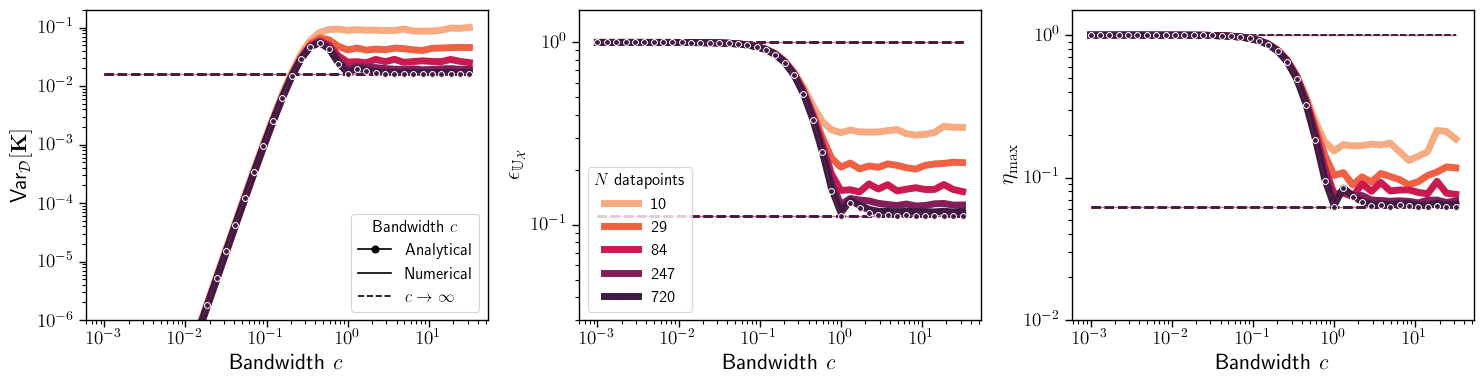

In [ ]:
# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Only num_qubits = 1 or 3 or 5

#kernels_nq = kernels_nq_d[(kernels_nq_d["num_datapoints"]==720)]

kernels_nq_datapoints = kernels_nq_d.copy()
kernels_nq_d_num_datapoints = kernels_nq_d[(kernels_nq_d["num_qubits"]==4)]

c_list = kernels_nq_d_num_datapoints["bandwidth"].unique()
num_qubits_list = kernels_nq_d_num_datapoints["num_qubits"].unique()
num_datapoint_list = kernels_nq_d_num_datapoints["num_datapoints"].unique()

progressive_palette = sns.color_palette("rocket_r", n_colors=len(num_datapoint_list))
colorblind_palette = sns.color_palette("colorblind", n_colors=len(num_datapoint_list))
selected_palette=progressive_palette

numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"

linewidth_size = 5

ax = axs[0]
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="varK_analytical", ax=ax, zorder=3, hue="num_datapoints", palette = selected_palette, legend=False, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_datapoints", palette = selected_palette, legend=False)
#sns.lineplot(data=kernels_nq, x="bandwidth", y="VarK_fit_flat", ax=ax, linewidth=linewidth_size,linestyle='-.', hue="num_qubits", palette = selected_palette)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="varK_analytical_large", ax=ax, linestyle='--', palette = selected_palette, legend=False, hue="num_datapoints", linewidth=intermediate_linewidth_size)

#create dummy legend for the markers
d1 = ax.plot([-1, -1], [-1, -2], "-o", color="black", label=analytical_str)
d2 = ax.plot([-1, -1], [-1, -2], "-", color="black", label=numerical_str)
d3 = ax.plot([-1, -1], [-1, -2], "--", color="black", label=large_str)
#delete d1, d2, d3
axs[0].legend(loc='lower right', title=bandwidth_str)

d1[0].remove()
d2[0].remove()
d3[0].remove()

# for num_qubits in num_qubits_list:
#     #sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_small", ax=ax, linestyle=':', color="gray", zorder=5, palette = selected_palette)
#     sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_large", ax=ax, linestyle=':', palette = selected_palette, legend=False)


ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[1]

sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="expressibility_analytical", ax=ax, zorder=3, hue="num_datapoints", palette = selected_palette, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5, legend=False)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="expressibility_analytical_small", ax=ax,  linestyle='--',hue="num_datapoints", palette = selected_palette, legend=False, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="expressibility_analytical_large", ax=ax,  linestyle='--',hue="num_datapoints",palette = selected_palette, legend=False, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="expressibility", ax=ax,  linewidth=linewidth_size,hue="num_datapoints", palette = selected_palette, legend=True)

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[2]
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="eta_max_analytical", ax=ax, zorder=3, hue="num_datapoints", palette = selected_palette, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5, legend=False)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="eta_max_analytical_small", ax=ax, linestyle='--',  hue="num_datapoints", palette = selected_palette)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="eta_max_analytical_large", ax=ax, linestyle='--',  hue="num_datapoints", palette = selected_palette, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq_d_num_datapoints, x="bandwidth", y="top_eigenvalue", ax=ax, linewidth=linewidth_size,  hue="num_datapoints", palette = selected_palette)
ax.get_legend().remove()


low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]


axs[1].legend(loc='lower left', title="$N$ datapoints")


axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[2].set_xscale("log")


ax.set_yscale("log")

expressibity_str = r"$\epsilon_{\mathbb{U}_{\mathcal{X}}}$"


kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc auc score"
top_eigenvalue_str = r"$\eta_{\mathrm{max}}$"
frobenius_str = r"$F(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
g_str = r"$g(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
bandwidth_str = "Bandwidth $c$"
varK_str = r"Var$_{\mathcal{D}}[\mathbf{K}]$"

axs[0].set_ylabel(varK_str)
axs[1].set_ylabel(expressibity_str)
axs[2].set_ylabel(top_eigenvalue_str)

axs[0].set_ylim(10**-6, 2*10**-1)
axs[1].set_ylim(3*10**-2, 1.5)
axs[2].set_ylim(10**-2, 1.5)

axs[0].set_xlabel(bandwidth_str)
axs[1].set_xlabel(bandwidth_str)
axs[2].set_xlabel(bandwidth_str)

# Reduce y separation between subplots
plt.tight_layout()

#reduce y separation between subplots
plt.subplots_adjust(hspace=0.02)


plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_Ndatapoints.pdf", bbox_inches='tight', dpi=500)
plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_Ndatapoints.png", bbox_inches='tight', dpi=500)


# Fig A11

C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_25304\296623705.py:32: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="varK_analytical", ax=ax, linestyle='--', zorder=3, hue="num_qubits", legend=False, palette=selected_palette, linewidth=intermediate_linewidth_size)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_25304\296623705.py:33: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_qubits", palette=selected_palette, legend = False)
C:\Users\jsl-rf\AppData\Local\Temp\ipykernel_25304\296623705.py:34: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(data=kernels_nq_large, x="num_datapoints", y="varK_train", ax=ax,hue="num_qubits", palette=selected_palet

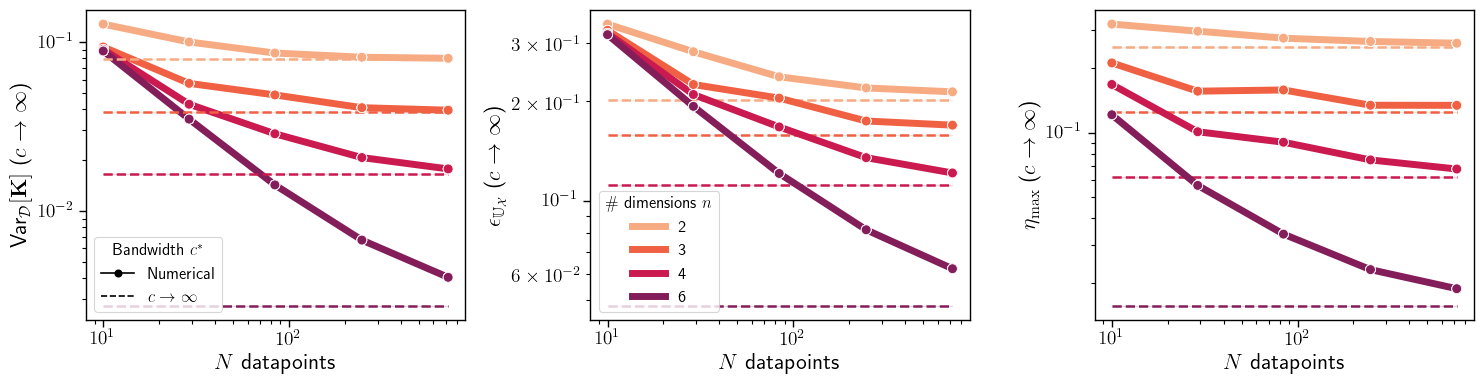

In [ ]:
# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Only num_qubits = 1 or 3 or 5
kernels_nq = kernels_nq_d.copy()

kernels_nq = kernels_nq_d[(kernels_nq_d["num_qubits"] == 2)  | (kernels_nq_d["num_qubits"] == 3) | (kernels_nq_d["num_qubits"] == 4) | (kernels_nq_d["num_qubits"] == 6)]


c_list = kernels_nq["bandwidth"].unique()
num_qubits_list = kernels_nq["num_qubits"].unique()
num_datapoint_list = kernels_nq["num_datapoints"].unique()

progressive_palette = sns.color_palette("coolwarm", n_colors=len(num_datapoint_list))
colorblind_palette = sns.color_palette("rocket_r", n_colors=len(num_datapoint_list))
selected_palette=colorblind_palette

numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"

linewidth_size = 5

ax = axs[0]

kernels_nq_large = kernels_nq[kernels_nq["bandwidth"] == bandwidth_list[29]]



sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="varK_analytical", ax=ax, linestyle='--', zorder=3, hue="num_qubits", legend=False, palette=selected_palette, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_qubits", palette=selected_palette, legend = False)
sns.scatterplot(data=kernels_nq_large, x="num_datapoints", y="varK_train", ax=ax,hue="num_qubits", palette=selected_palette, s=50, zorder=10, legend = False)

#sns.lineplot(data=kernels_nq, x="bandwidth", y="VarK_fit_flat", ax=ax, linewidth=linewidth_size,linestyle='-.', hue="num_qubits")


ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[1]
sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="expressibility_analytical_large", ax=ax,  linestyle='--',hue="num_qubits", palette=selected_palette,linewidth=intermediate_linewidth_size, legend = False)
sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="expressibility", ax=ax,  linewidth=linewidth_size,hue="num_qubits", palette=selected_palette)
sns.scatterplot(data=kernels_nq_large, x="num_datapoints", y="expressibility", ax=ax,hue="num_qubits", palette=selected_palette, s=50, zorder=10, legend = False)
ax.get_legend().remove()

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[2]
sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="eta_max_analytical_large", ax=ax, linestyle='--',  hue="num_qubits", palette=selected_palette, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq_large, x="num_datapoints", y="top_eigenvalue", ax=ax, linewidth=linewidth_size,  hue="num_qubits", palette=selected_palette)
sns.scatterplot(data=kernels_nq_large, x="num_datapoints", y="top_eigenvalue", ax=ax,hue="num_qubits", palette=selected_palette, s=50, zorder=10)

ax.get_legend().remove()




low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]


axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[2].set_xscale("log")


ax.set_yscale("log")

kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc_auc_score"
top_eigenvalue_str = r"$\eta_{max}$"
bandwidth_str = "Bandwidth $c$"
varK_str = r"Var$[k(\mathbf x,\mathbf y)]$"
expressibity_str = "$\epsilon_{\mathcal{U}}$"
num_datapoints_str = "$N$ datapoints"

expressibity_str = r"$\epsilon_{\mathbb{U}_{\mathcal{X}}}$"


kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc auc score"
top_eigenvalue_str = r"$\eta_{\mathrm{max}}$"
frobenius_str = r"$F(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
g_str = r"$g(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
bandwidth_str = "Bandwidth $c^*$"
varK_str = r"Var$_{\mathcal{D}}[\mathbf{K}]$"

axs[0].set_ylabel(varK_str + r" ($c\rightarrow \infty$)")
axs[1].set_ylabel(expressibity_str + r" ($c\rightarrow \infty$)")
axs[2].set_ylabel(top_eigenvalue_str + r" ($c\rightarrow \infty$)")

#axs[0].set_ylim(0.1*10**-2, 2*10**-1)
#axs[1].set_ylim(4*10**-2, 0.5)
#axs[2].set_ylim(0.15*10**-1, 1.5)

axs[0].set_xlabel(num_datapoints_str)
axs[1].set_xlabel(num_datapoints_str)
axs[2].set_xlabel(num_datapoints_str)

# Reduce y separation between subplots
plt.tight_layout()

axs[1].legend(loc='lower left', title=num_qubit_str)


#reduce y separation between subplots
plt.subplots_adjust(hspace=0.02)



ax = axs[0]
#d1 = ax.plot([-1, -1], [-1, -2], "-o", color="black", label=analytical_str)
d2 = ax.plot([-1, -1], [-1, -2], "-o", color="black", label=numerical_str)
d3 = ax.plot([-1, -1], [-1, -2], "--", color="black", label=large_str)
#delete d1, d2, d3
axs[0].legend(loc='lower left', title=bandwidth_str)


#remove d2 and d3
d2[0].remove()
d3[0].remove()



plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_as_a_function_of_N_large_bandwidth.pdf", bbox_inches='tight', dpi=500)
plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_as_a_function_of_N_large_bandwidth.png", bbox_inches='tight', dpi=500)


# Not on paper plots

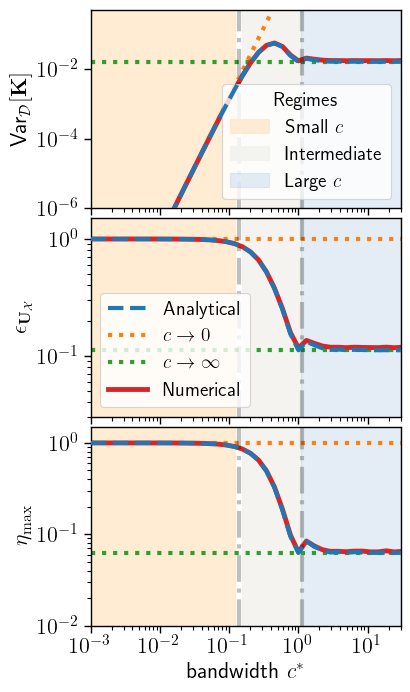

In [ ]:
#make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

fig, axs = plt.subplots(3, 1, figsize=(4, 8), sharex=True)

#only nq = 1
kernels_nq = kernels[kernels["num_qubits"] == 4]

c_list = kernels_nq["bandwidth"].unique()

numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"

linewidth_size = 3.5

ax = axs[0]
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax,  linestyle='--', zorder=10)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_small", ax=ax, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_large", ax=ax,  linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_numerical", ax=ax, linewidth = linewidth_size )

ax.set_yscale("log")
ax.set_xscale("log")


ax = axs[1]
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", ax=ax, label =analytical_str, linestyle='--', zorder=10)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", ax=ax, label =small_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", ax=ax, label=large_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_numerical", ax=ax, label=numerical_str, linewidth = linewidth_size )

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[2]
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", ax=ax, label =analytical_str, linestyle='--', zorder=10)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small", ax=ax, label =small_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", ax=ax, label=large_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_numerical", ax=ax, label=numerical_str, linewidth = linewidth_size )
ax.get_legend().remove()


low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]

c_list_continuous = np.linspace(10**-3, 30, 1000)
for i in range(3):
    ax = axs[i]
    ax.axvline(x=low_c_border-0.01, color="black", linestyle="-.", alpha=0.25)
    ax.axvline(x=high_c_border+0.01, color="black", linestyle="-.", alpha=0.25)

    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous < low_c_border), color='#ffeacf', alpha=0.90, label=labels[0])
    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous > low_c_border) & (c_list_continuous <= high_c_border), color="#f3f2ee", alpha=0.90, label=labels[1])
    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous > high_c_border), color='#96badc', alpha=0.25, label=labels[2])
    ax.set_xlim(10**-3, 30)


axs[0].legend( loc='best', title="Regimes")

ax.set_yscale("log")
ax.set_xscale("log")


kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc_auc_score"
top_eigenvalue_str = r"$\eta_{max}$"
bandwidth_str = "Bandwidth $c$"
varK_str = r"Var$[k(\mathbf x,\mathbf y)]$"

expressibity_str = "$\epsilon_{\mathcal{U}}$"
expressibity_str = r"$\epsilon_{\mathbf{U}_{\mathcal{X}}}$"


kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc auc score"
top_eigenvalue_str = r"$\eta_{\mathrm{max}}$"
frobenius_str = r"$F(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
g_str = r"$g(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
bandwidth_str = "bandwidth $c^*$"
varK_str = r"Var$_{\mathcal{D}}[\mathbf{K}]$"


axs[0].set_ylabel(varK_str)
axs[1].set_ylabel(expressibity_str)
axs[2].set_ylabel(top_eigenvalue_str)

axs[0].set_ylim(10**-6, 5*10**-1)
axs[1].set_ylim(3*10**-2, 1.5)
axs[2].set_ylim(10**-2, 1.5)


axs[2].set_xlabel(bandwidth_str)


#reduce y separation between subplots
plt.subplots_adjust(hspace=0.05)

plt.savefig("../data/plots/analytical_vs_numerical_separable_rx.pdf", bbox_inches='tight', dpi=500)
plt.savefig("../data/plots/analytical_vs_numerical_separable_rx.png", bbox_inches='tight', dpi=500)

In [ ]:
# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

sns.set_context("paper", rc={"font.size":12,"axes.titlesize":16,"axes.labelsize":16, 
                                "legend.fontsize":12, "xtick.labelsize":14, 
                                "ytick.labelsize":14, "legend.title_fontsize":12, })


sc=0.85
fig, axs = plt.subplots(3, 1, figsize=(7*sc, 8.5*sc))

# Only num_qubits = 1 or 3 or 5
#kernels_nq = kernels[(kernels["num_qubits"] == 1)  | (kernels["num_qubits"] == 4)]

kernels_nq = kernels_nq_d[(kernels_nq_d["num_datapoints"]==720)]

c_list = kernels_nq["bandwidth"].unique()
num_qubits_list = kernels_nq["num_qubits"].unique()

progressive_palette = sns.color_palette("rocket_r", n_colors=len(num_qubits_list))
colorblind_palette = sns.color_palette("colorblind", n_colors=len(num_qubits_list))
selected_palette=progressive_palette


numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"

linewidth_size = 5
intermediate_linewidth_size = 1.8
thinlinewidth_size = 0.05
scatter_size = 12

marker_size = 4

ax = axs[0]
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax, zorder=3, hue="num_qubits", palette = selected_palette, legend=False, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_qubits", palette = selected_palette, legend=False)
#sns.lineplot(data=kernels_nq, x="bandwidth", y="VarK_fit_flat", ax=ax, linewidth=linewidth_size,linestyle='-.', hue="num_qubits", palette = selected_palette)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_large", ax=ax, linestyle='--', palette = selected_palette, legend=False, hue="num_qubits", linewidth=intermediate_linewidth_size)

#create dummy legend for the markers
d1 = ax.plot([-1, -1], [-1, -2], "-o", color="black", label=analytical_str)
d2 = ax.plot([-1, -1], [-1, -2], "-", color="black", label=numerical_str)
d3 = ax.plot([-1, -1], [-1, -2], "--", color="black", label=large_str)
#delete d1, d2, d3
axs[0].legend(loc='lower right', title=bandwidth_str)

d1[0].remove()
d2[0].remove()
d3[0].remove()

# for num_qubits in num_qubits_list:
#     #sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_small", ax=ax, linestyle=':', color="gray", zorder=5, palette = selected_palette)
#     sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_large", ax=ax, linestyle=':', palette = selected_palette, legend=False)


ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[2]

sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", ax=ax, zorder=3, hue="num_qubits", palette = selected_palette, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5, legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", ax=ax,  linestyle='--',hue="num_qubits", palette = selected_palette, legend=False, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", ax=ax,  linestyle='--',hue="num_qubits",palette = selected_palette, legend=False, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility", ax=ax,  linewidth=linewidth_size,hue="num_qubits", palette = selected_palette, legend=True)

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[1]
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", ax=ax, zorder=3, hue="num_qubits", palette = selected_palette, marker="o",  linewidth=thinlinewidth_size, markersize=marker_size, markeredgewidth=0.5, legend=False)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small", ax=ax, linestyle='--',  hue="num_qubits", palette = selected_palette)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", ax=ax, linestyle='--',  hue="num_qubits", palette = selected_palette, linewidth=intermediate_linewidth_size)
sns.lineplot(data=kernels_nq, x="bandwidth", y="top_eigenvalue", ax=ax, linewidth=linewidth_size,  hue="num_qubits", palette = selected_palette)
ax.get_legend().remove()



low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]

axs[2].legend(loc='lower left', title=num_qubit_str)


axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[2].set_xscale("log")



ax.set_yscale("log")

kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc_auc_score"
top_eigenvalue_str = r"$\eta_{max}$"
bandwidth_str = "Bandwidth $c$"
varK_str = r"Var$[k(\mathbf x,\mathbf y)]$"
expressibity_str = "$\epsilon_{\mathcal{U}}$"

axs[0].set_ylabel(varK_str)
axs[1].set_ylabel(expressibity_str)
axs[2].set_ylabel(top_eigenvalue_str)



axs[0].set_ylim(10**-6, 2*10**-1)
axs[1].set_ylim(10**-2, 1.5)
axs[2].set_ylim(10**-2, 1.5)


# axs[0].set_ylim(10**-10, 10**2)
# axs[1].set_ylim(10**-3, 10)  
# axs[2].set_ylim(10**-2, 1.5)

axs[0].set_xlabel(bandwidth_str)
axs[1].set_xlabel(bandwidth_str)
axs[2].set_xlabel(bandwidth_str)


#include title
axs[0].set_title("Separable $R_X$ Kernel")
#    ax.set_xticks([10**i for i in range(-4, 2, 1)])

# Reduce y separation between subplots
plt.tight_layout()

#reduce y separation between subplots
plt.subplots_adjust(hspace=0.02)


#plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_uniform_distribution.pdf", bbox_inches='tight', dpi=500)
#plt.savefig("../data/plots/analytical_vs_numerical_separable_rx_uniform_distribution.png", bbox_inches='tight', dpi=500)


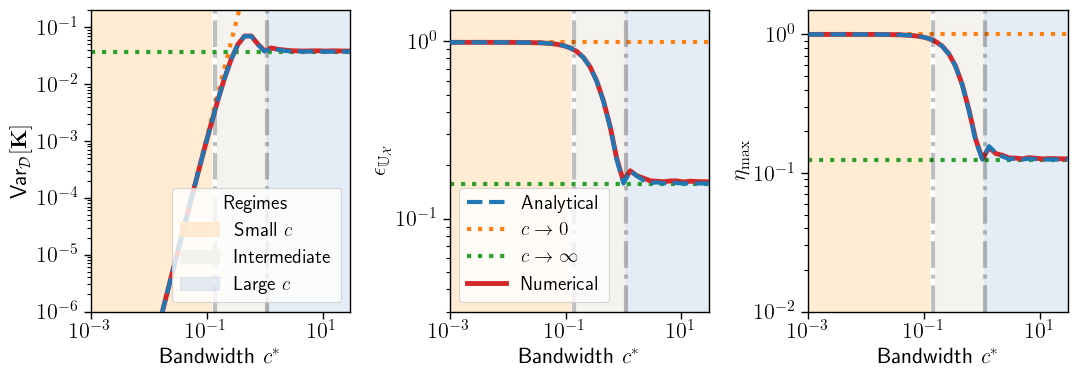

In [ ]:
# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharex=True)

# Only nq = 1
kernels_nq = kernels[kernels["num_qubits"] == 3]

c_list = kernels_nq["bandwidth"].unique()

numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"

linewidth_size = 3.5

ax = axs[0]
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax, linestyle='--', zorder=3)
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_small", ax=ax, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical_large", ax=ax, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_numerical", ax=ax, linewidth=linewidth_size)

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[1]
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", ax=ax, label=analytical_str, linestyle='--', zorder=3)
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", ax=ax, label=small_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", ax=ax, label=large_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_numerical", ax=ax, label=numerical_str, linewidth=linewidth_size)

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[2]
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", ax=ax, label=analytical_str, linestyle='--', zorder=3)
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small", ax=ax, label=small_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", ax=ax, label=large_str, linestyle=':')
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_numerical", ax=ax, label=numerical_str, linewidth=linewidth_size)
ax.get_legend().remove()

low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]

c_list_continuous = np.linspace(10**-3, 30, 1000)
for i in range(3):
    ax = axs[i]
    ax.axvline(x=low_c_border-0.01, color="black", linestyle="-.", alpha=0.25)
    ax.axvline(x=high_c_border+0.01, color="black", linestyle="-.", alpha=0.25)

    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous < low_c_border), color='#ffeacf', alpha=0.90, label=labels[0])
    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous > low_c_border) & (c_list_continuous <= high_c_border), color="#f3f2ee", alpha=0.90, label=labels[1])
    ax.fill_between(c_list_continuous, 0, 50, where=(c_list_continuous > high_c_border), color='#96badc', alpha=0.25, label=labels[2])
    ax.set_xlim(10**-3, 30)

axs[0].legend(loc='lower right', title="Regimes")

ax.set_yscale("log")
ax.set_xscale("log")


expressibity_str = "$\epsilon_{\mathcal{U}}$"
expressibity_str = r"$\epsilon_{\mathbb{U}_{\mathcal{X}}}$"


kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc auc score"
top_eigenvalue_str = r"$\eta_{\mathrm{max}}$"
frobenius_str = r"$F(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
g_str = r"$g(\mathbf{K}_{\mathrm{C}}, \mathbf{K}_{\mathrm{Q}})$"
bandwidth_str = "Bandwidth $c^*$"
varK_str = r"Var$_{\mathcal{D}}[\mathbf{K}]$"

axs[0].set_ylabel(varK_str)
axs[1].set_ylabel(expressibity_str)
axs[2].set_ylabel(top_eigenvalue_str)

axs[0].set_ylim(10**-6, 2*10**-1)
axs[1].set_ylim(3*10**-2, 1.5)
axs[2].set_ylim(10**-2, 1.5)

axs[0].set_xlabel(bandwidth_str)
axs[1].set_xlabel(bandwidth_str)
axs[2].set_xlabel(bandwidth_str)

# Reduce y separation between subplots
plt.tight_layout()

#reduce y separation between subplots
plt.subplots_adjust(hspace=0.02)

plt.savefig("../data/plots/analytical_vs_numerical_separable_rx.pdf", bbox_inches='tight', dpi=500)
plt.savefig("../data/plots/analytical_vs_numerical_separable_rx.png", bbox_inches='tight', dpi=500)


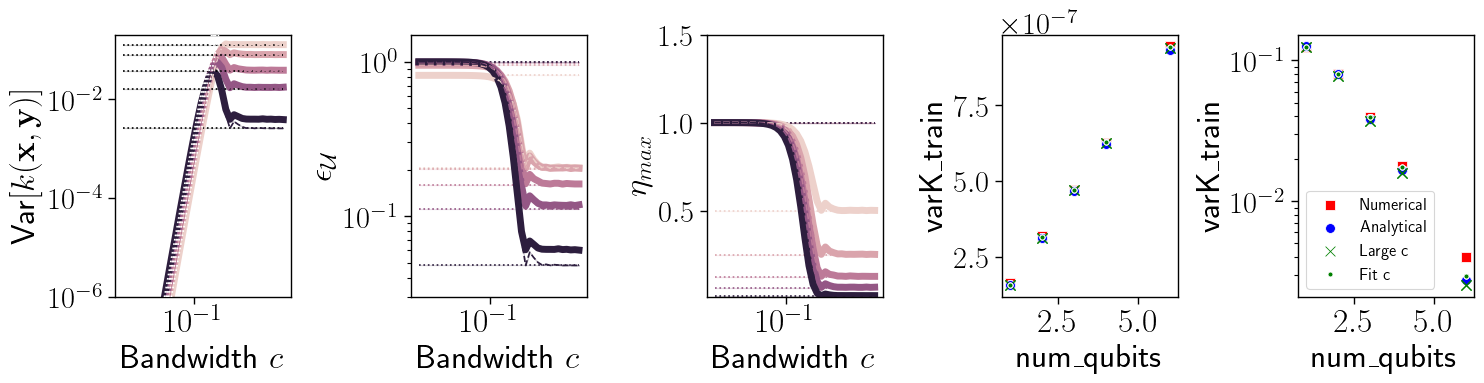

In [ ]:
# Make a line plot of varK_analytical, varK_analytical_small, varK_analytical_large, varK_numerical using sns in log scale

fig, axs = plt.subplots(1, 5, figsize=(15, 4))

# Only num_qubits = 1 or 3 or 5
#kernels_nq = kernels[(kernels["num_qubits"] == 1)  | (kernels["num_qubits"] == 4)]

kernels_nq = kernels_nq_d[(kernels_nq_d["num_datapoints"]==720)]

c_list = kernels_nq["bandwidth"].unique()
num_qubits_list = kernels_nq["num_qubits"].unique()

progressive_palette = sns.color_palette("viridis", n_colors=len(num_qubits_list))
colorblind_palette = sns.color_palette("colorblind", n_colors=len(num_qubits_list))


numerical_str = "Numerical"
analytical_str = "Analytical"
small_str = r"$c \rightarrow 0$"
large_str = r"$c \rightarrow \infty$"

linewidth_size = 5

ax = axs[0]
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_analytical", ax=ax, linestyle='--', zorder=3, hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="varK_train", ax=ax, linestyle='-', linewidth=linewidth_size, hue="num_qubits")
#sns.lineplot(data=kernels_nq, x="bandwidth", y="VarK_fit_flat", ax=ax, linewidth=linewidth_size,linestyle='-.', hue="num_qubits")


for num_qubits in num_qubits_list:
    sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_small", ax=ax, linestyle=':', color="white", zorder=5)
    sns.lineplot(data=kernels_nq[kernels_nq["num_qubits"] == num_qubits], x="bandwidth", y="varK_analytical_large", ax=ax, linestyle=':', color="black")


ax.get_legend().remove()

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[1]
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical", ax=ax, linestyle='--', zorder=3,hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_small", ax=ax,  linestyle=':',hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility_analytical_large", ax=ax,  linestyle=':',hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="expressibility", ax=ax,  linewidth=linewidth_size,hue="num_qubits")
ax.get_legend().remove()

ax.set_yscale("log")
ax.set_xscale("log")

ax = axs[2]
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical", ax=ax, linestyle='--', zorder=3,  hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_small", ax=ax, linestyle=':',  hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="eta_max_analytical_large", ax=ax, linestyle=':',  hue="num_qubits")
sns.lineplot(data=kernels_nq, x="bandwidth", y="top_eigenvalue", ax=ax, linewidth=linewidth_size,  hue="num_qubits")
ax.get_legend().remove()


ax = axs[3]
kernels_nq_small = kernels_nq[kernels_nq["bandwidth"] == bandwidth_list[10]]

sns.scatterplot(data=kernels_nq_small, x="num_qubits", y="varK_train", ax=ax, marker='s', s=50, color='red', label='Numerical')
sns.scatterplot(data=kernels_nq_small, x="num_qubits", y="varK_analytical", ax=ax, marker='o', s=50, color='blue', label='Analytical')
sns.scatterplot(data=kernels_nq_small, x="num_qubits", y="varK_analytical_small", ax=ax, marker='x', s=50, color='green', label='Small c')
sns.scatterplot(data=kernels_nq_small, x="num_qubits", y="VarK_fit_flat", ax=ax, marker='.', s=50, color='green', label='Fit c')
ax.get_legend().remove()



ax = axs[4]
kernels_nq_large = kernels_nq[kernels_nq["bandwidth"] == bandwidth_list[29]]
sns.scatterplot(data=kernels_nq_large, x="num_qubits", y="varK_train", ax=ax, marker='s', s=50, color='red', label='Numerical')
sns.scatterplot(data=kernels_nq_large, x="num_qubits", y="varK_analytical", ax=ax, marker='o', s=50, color='blue', label='Analytical')
sns.scatterplot(data=kernels_nq_large, x="num_qubits", y="varK_analytical_large", ax=ax, marker='x', s=50, color='green', label='Large c')
sns.scatterplot(data=kernels_nq_large, x="num_qubits", y="VarK_fit_exp", ax=ax, marker='.', s=50, color='green', label='Fit c')


low_c_border = 0.15
high_c_border = 1.10

labels = ["Small $c$", "Intermediate", "Large $c$"]


axs[0].legend(loc='lower right', title="Regimes")
axs[0].get_legend().remove()


axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[2].set_xscale("log")


ax.set_yscale("log")

kernel_type_str = "Kernel "
num_qubit_str = "$\#$ dimensions $n$"
performance_str = "roc_auc_score"
top_eigenvalue_str = r"$\eta_{max}$"
bandwidth_str = "Bandwidth $c$"
varK_str = r"Var$[k(\mathbf x,\mathbf y)]$"
expressibity_str = "$\epsilon_{\mathcal{U}}$"

axs[0].set_ylabel(varK_str, )
axs[1].set_ylabel(expressibity_str)
axs[2].set_ylabel(top_eigenvalue_str)

axs[0].set_ylim(10**-6, 2*10**-1)
axs[1].set_ylim(3*10**-2, 1.5)
axs[2].set_ylim(10**-2, 1.5)

axs[0].set_xlabel(bandwidth_str)
axs[1].set_xlabel(bandwidth_str)
axs[2].set_xlabel(bandwidth_str)

# Reduce y separation between subplots
plt.tight_layout()

#reduce y separation between subplots
plt.subplots_adjust(hspace=0.02)


#plt.savefig("../data/plots/analytical_vs_numerical_separable_rx.pdf", bbox_inches='tight', dpi=500)
#plt.savefig("../data/plots/analytical_vs_numerical_separable_rx.png", bbox_inches='tight', dpi=500)
